In [1]:
% matplotlib inline

import numpy as np, nibabel as nib
import utils.plotting_lighterbg as plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import statsmodels.formula.api as smf

sns.set_style('white')
sns.set_context('talk')

/home/raid3/oligschlager/anaconda2/envs/distconnect/lib/python2.7/site-packages/nibabel/cifti2/parse_cifti2.py:24: FutureWarning: We no longer carry a copy of the 'six' package in nibabel; Please import the 'six' package directly
  from ..externals.six import BytesIO


In [2]:
ddir = '/nobackup/hunte1/sabine/data/macaque/resting'

#f_mdist = '%s/meandist/%s/maps_awake/lh.meandist.10k_fs_LR.nii.gz' % (ddir, monkey)
f_cort = '%s/surf/MacaqueYerkes19.L.atlasroi.10k_fs_LR.shape.gii' % ddir
f_surf = '%s/surf/Surface/%s/NativeSpace/%s.L.inflated.10k_fs_LR.surf.gii' % (ddir, 'Willow', 'Willow')
f_sulc = '%s/surf/Surface/%s/NativeSpace/%s.L.sulc.10k_fs_LR.shape.gii' % (ddir, 'Willow', 'Willow')

In [3]:
cort = np.where(nib.load(f_cort).darrays[0].data==1)[0]
coords = nib.load(f_surf).darrays[0].data
faces = nib.load(f_surf).darrays[1].data
sulc = nib.load(f_sulc).darrays[0].data

## fucntional connectivity distance

In [4]:
# average across monkeys

mdist = np.zeros(coords.shape[0])

for monkey in ['Randi', 'Willow']:
    
    f_mdist = '%s/meandist/%s/maps_awake/lh.meandist.10k_fs_LR.nii.gz' % (ddir, monkey)
    mdist += nib.load(f_mdist).get_data().squeeze()
    
mdist = mdist / 2

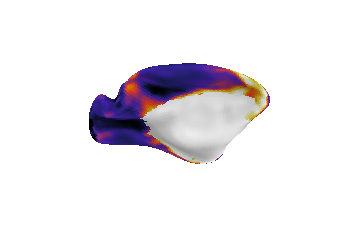

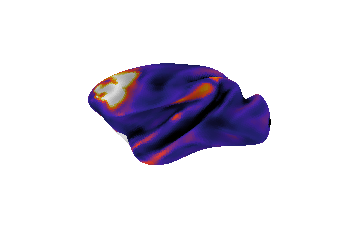

In [5]:
# avg
for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  bg_map=sulc,
                                  bg_on_stat=True,
                                  alpha=1,
                                  vmin=5,
                                  vmax=20,
                                  azim=azim,
                                  cmap='CMRmap')
    
    
    #plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/condist_%s' % (azim), dpi=300)

## distance from primary cortex

In [6]:
import gdist
from surfdist.utils import surf_keep_cortex, translate_src, recort

vertices, triangles = surf_keep_cortex((coords, faces), cort)

def dist_calc_fast(src, cortex, vertices, triangles, surf):
    src_new = translate_src(src, cortex)
    data = gdist.compute_gdist(vertices, triangles, source_indices=src_new)
    dist = recort(data, surf, cortex)
    del data
    return dist

In [7]:
# surf midthickness for dist calc
# maybe average distances for the two monkeys

# macaque surface for dist
f_surf_mid = '%s/surf/Surface/Willow/NativeSpace/Willow.L.midthickness.10k_fs_LR.surf.gii' % ddir
coords_mid = nib.load(f_surf_mid).darrays[0].data
faces_mid = nib.load(f_surf_mid).darrays[1].data
surf_mid = tuple((coords_mid, faces_mid))

In [8]:
f_atlas = '%s/surf/L.MarkovCC12_M132_91-area.10k_fs_LR.label.gii' % ddir
atlas = nib.load(f_atlas)#.darrays[0].data

In [9]:
prim_names = ['V1', 'CORE', 'F1', '3']
prim_keys = [83, 36, 39, 3]

In [10]:
prim_dist = np.empty((len(prim_keys), 
                     coords.shape[0]))

for n, key in enumerate(prim_keys):
    
    prim_dist[n] = dist_calc_fast(np.where(atlas.darrays[0].data==key)[0], 
                                  cort, vertices, triangles, surf_mid)
    
prim_dist = np.min(prim_dist, axis=0)

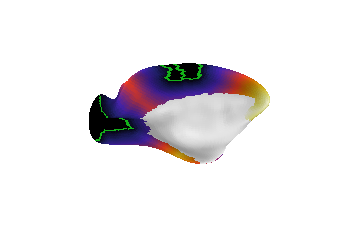

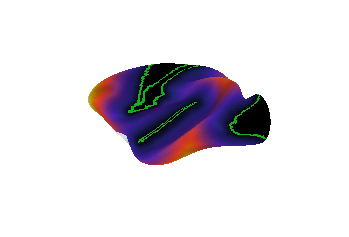

In [11]:
labels_prim = [np.where(atlas.darrays[0].data==key)[0] for key in prim_keys]

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=cort,
                                  labels = labels_prim, 
                                  azim=azim,
                                  bg_map=sulc, bg_on_stat=True, 
                                  cmap='CMRmap')
    
    #plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/primdist_%s' % (azim), dpi=300)

In [12]:
print prim_dist.min(), prim_dist.max()

0.0 30.7347463355


## Relationship of functional connectivity distance with distance from primary cortex

### exclude anteriormost PFC due to deviating patterns and also the primary regions themselves

In [13]:
excl_areas = ['9', '10', '11', '12', '46d', '46v', '9/46d', '9/46v']
excl_keys = [5, 6, 7, 8, 23, 24, 33, 34]

excl_areas_and_prim = ['9', '10', '11', '12', '46d', '46v', '9/46d', '9/46v'] + prim_names
excl_keys_and_prim = [5, 6, 7, 8, 23, 24, 33, 34] + prim_keys

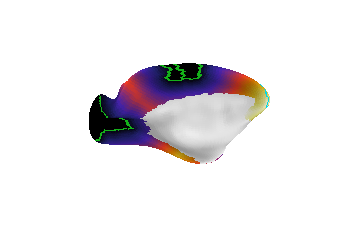

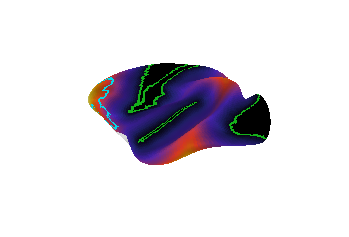

In [14]:
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)


labels_prim = [np.where(atlas.darrays[0].data==key)[0] for key in prim_keys]

#labels = labels_prim + label_excl_area
labels_prim.append(label_excl_areas)

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=cort,
                                  labels = labels_prim,#label_excl_area,
                                  label_cpal = ["green", "green", "green", "green", "aqua blue"],
                                  azim=azim,
                                  sulc=sulc, bg_map=sulc, 
                                  bg_on_stat=True, cmap='CMRmap')

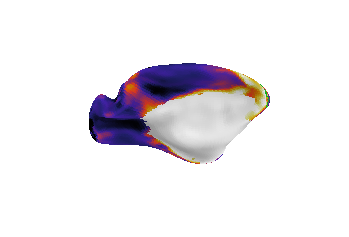

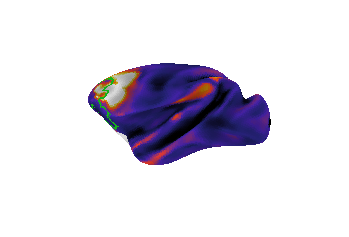

In [15]:
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = [np.array(label_excl_areas),]


for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  labels = label_excl_areas, 
                                  azim=azim,
                                  vmin=5,
                                  vmax=20,
                                  sulc=sulc,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

In [16]:
# mask out anterior PFC
nodes_excl = list()
for n in excl_keys:
    nodes_excl.extend(np.where(atlas.darrays[0].data==n)[0])
    
mask = np.array([node for node in cort if node not in nodes_excl])

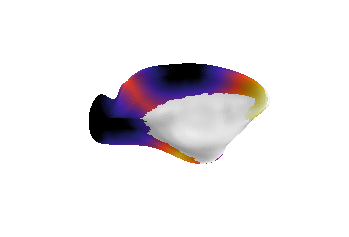

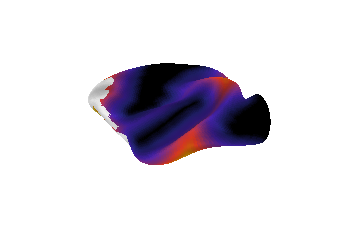

In [17]:
for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=mask,
                                  #labels = labels, 
                                  azim=azim,
                                  sulc=sulc,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap')
    
    #plt.savefig('/home/raid3/oligschlager/Downloads/gdist_from_prim_%s' % (azim),
     #           dpi=300)

In [18]:
# mask out primary areas
nodes_excl = list()
for n in excl_keys_and_prim:
    nodes_excl.extend(np.where(atlas.darrays[0].data==n)[0])
    
mask_prim_xcl = np.array([node for node in cort if node not in nodes_excl])

### Area-wise relationship

In [20]:
annot = np.array([atlas.labeltable.get_labels_as_dict()[key] for key in atlas.darrays[0].data])
annot.shape

(10242,)

In [21]:
df = pd.DataFrame({'area': annot, 
                   'meandist': mdist, 
                   'primdist': prim_dist})

df['area'] = df['area'].astype(str).values

print df.shape
df.head()

(10242, 3)


,area,meandist,primdist
0,23,8.088145,7.271953
1,V6A,8.678762,7.265151
2,2,7.436706,2.262008
3,F1,7.752873,0.000000
4,V1,8.657006,0.000000


In [22]:
df_area = df.groupby('area').mean()

order = df_area.sort_values(by='primdist').index
order = [str(area) for area in order]

In [23]:
df_area = df_area.reset_index()

df_area.head()

,area,meandist,primdist
0,1,7.371935,1.347755
1,10,10.242113,27.641260
2,11,7.838133,24.529078
3,12,7.351674,15.395721
4,13,7.813853,22.088094


In [24]:
# on the surface
mdist_parcels = np.array([df_area.meandist[df_area.area==node].iloc[0] for node in annot])
primdist_parcels = np.array([df_area.primdist[df_area.area==node].iloc[0] for node in annot])

In [25]:
sns.set_context('poster')

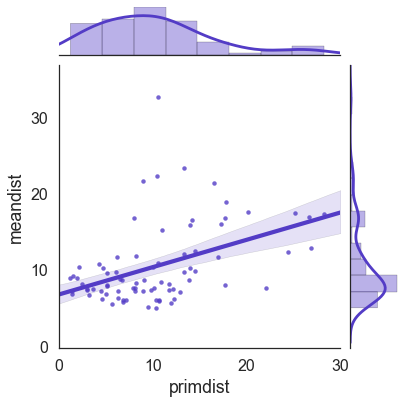

In [27]:
reg_filtr = (~df_area.area.isin(excl_areas_and_prim)) & (df_area.area != '???')

g = sns.jointplot(x="primdist", y="meandist", data=df_area[reg_filtr], kind='reg', 
                  color="#533cc6", 
                  xlim=(0,30), ylim=(0,37),
                  stat_func=None)


plt.xticks([0,10,20,30])
plt.yticks([0,10,20,30])


g.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/relationship_func_mask.png', dpi=300)

### stats

In [28]:
model = smf.ols(formula='meandist ~ primdist', data=df_area).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               meandist   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     21.46
Date:                Mon, 11 Dec 2017   Prob (F-statistic):           1.21e-05
Time:                        10:33:03   Log-Likelihood:                -267.93
No. Observations:                  92   AIC:                             539.9
Df Residuals:                      90   BIC:                             544.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.2274      0.846      8.543      0.0

In [29]:
# exclude anteriormost prefrontal areas

model = smf.ols(formula='meandist ~ primdist', data=df_area[reg_filtr]).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               meandist   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     18.62
Date:                Mon, 11 Dec 2017   Prob (F-statistic):           4.69e-05
Time:                        10:33:03   Log-Likelihood:                -232.01
No. Observations:                  79   AIC:                             468.0
Df Residuals:                      77   BIC:                             472.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.9666      0.998      6.982      0.0

### Peaks of connectivity distance

In [32]:
df_area[df_area.meandist>20] 
# it was rather the posterior parts of the prefrontal cortex such area 8 and 45 that peaked



,area,meandist,primdist
19,45B,22.412930,10.470833
28,8l,32.749574,10.557328
29,8m,21.782900,8.927106
30,8r,23.544647,13.320698
71,SUBICULUM,21.514451,16.464733


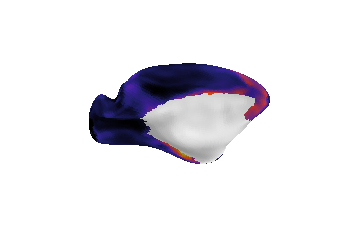

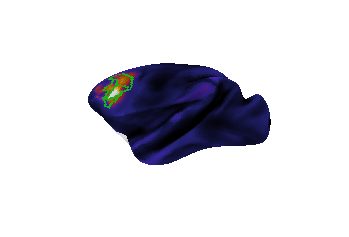

In [33]:
label_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 
#['45B', '8l', '8m', '8r']

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  azim=azim,
                                  vmin=5,
                                  vmax=40,
                                  sulc=sulc,
                                  labels=label_peak_areas,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

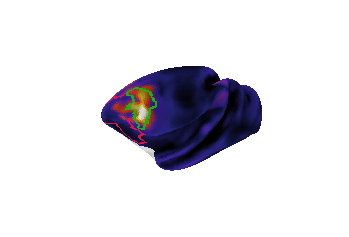

In [34]:
# zoom into PFC


# anteriormost excluded PFC areas
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)



# PFC peak areas
labels_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 

label_peak_areas = list()

for l in labels_peak_areas:
    label_peak_areas += list(l)
    
label_peak_areas = [np.array(label_peak_areas),]




img = plot.plot_surf_stat_map(coords, faces,
                              mdist, mask=cort,
                              labels = [label_excl_areas]+label_peak_areas,
                              label_cpal = ['lipstick', 'green'],#"clear blue"],
                              azim=145,
                              elev=25,
                              vmin=5,
                              vmax=35,
                              sulc=sulc,
                              bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

#plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/pfc', dpi=300)

In [35]:
label_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 

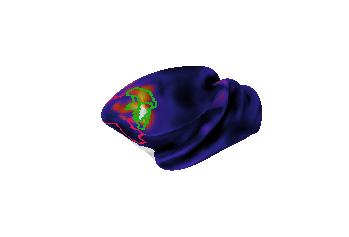

In [36]:
# zoom into PFC


# anteriormost excluded PFC areas
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)



# PFC peak areas
#labels_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 

#label_peak_areas = list()

#for l in labels_peak_areas:
#    label_peak_areas += list(l)
    
#label_peak_areas = [np.array(label_peak_areas),]




img = plot.plot_surf_stat_map(coords, faces,
                              mdist, mask=cort,
                              labels = [label_excl_areas]+label_peak_areas,
                              label_cpal = ['lipstick', 'green', 'green', 'green', 'green'],#"clear blue"],
                              azim=145,
                              elev=25,
                              vmin=5,
                              vmax=35,
                              sulc=sulc,
                              bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

#plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/pfc', dpi=300)

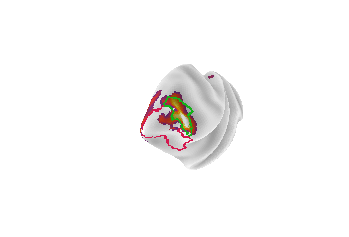

In [37]:
# zoom into PFC


# anteriormost excluded PFC areas
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)



# PFC peak areas
labels_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 

label_peak_areas = list()

for l in labels_peak_areas:
    label_peak_areas += list(l)
    
label_peak_areas = [np.array(label_peak_areas),]



for elev in [30]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  labels = [label_excl_areas]+label_peak_areas,
                                  label_cpal = ['lipstick', 'green'],#"clear blue"],
                                  azim=110, #check 120...
                                  elev=elev,
                                  vmin=5,
                                  vmax=35,
                                  sulc=sulc,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap',
                                  threshold=15)

#plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/pfc2', dpi=300)

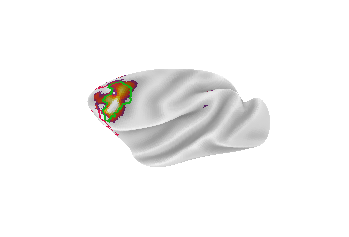

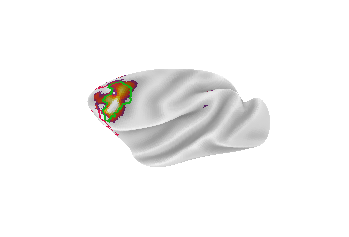

In [38]:
# zoom into PFC


# anteriormost excluded PFC areas
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)



# PFC peak areas
labels_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 

label_peak_areas = list()

for l in labels_peak_areas:
    label_peak_areas += list(l)
    
label_peak_areas = [np.array(label_peak_areas),]



for azim in [50, 80]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  labels = [label_excl_areas]+label_peak_areas,
                                  label_cpal = ['lipstick', 'green'],#"clear blue"],
                                  azim=180, #check 120...
                                  elev=elev,
                                  vmin=5,
                                  vmax=35,
                                  sulc=sulc,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap',
                                  threshold=15)

#plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/pfc2', dpi=300)

### visualize as parcels

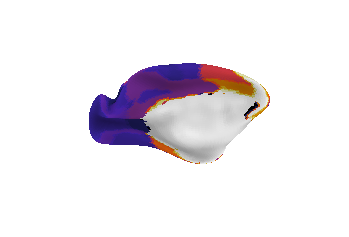

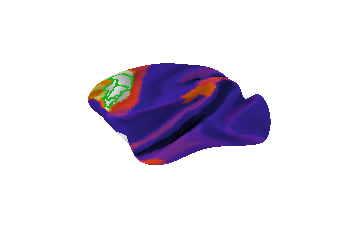

In [39]:
label_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 
#['45B', '8l', '8m', '8r']

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist_parcels, mask=cort,
                                  azim=azim,
                                  vmin=5,
                                  vmax=17,
                                  sulc=sulc,
                                  labels=label_peak_areas,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

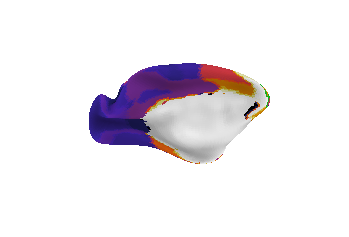

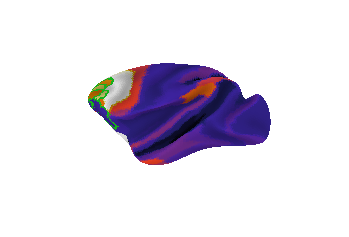

In [40]:
label_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist_parcels, mask=cort,
                                  azim=azim,
                                  vmin=5,
                                  vmax=17,
                                  sulc=sulc,
                                  labels=label_excl_area,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

# Supplementaries: Comparingtract-tracing and functional connectivity data

In [42]:
df_tract = pd.read_pickle('/home/raid3/oligschlager/workspace/tractdist/data/df_regionwise.pkl')
df_tract.shape

(91, 26)

In [43]:
df_tract = df_tract.rename(columns={'injection distance from nearest primary region': "dist_inj_prim",
                                    'injection distance from nearest DMN region': "dist_inj_dmn"})

In [44]:
d = {'29/30': '29_30',
     '9/46d': '9_46d',
     '9/46v': '9_46v',
     'ENTORHINAL': 'Ento',
     'INSULA': 'Ins',
     'OPRO': 'Opro',
     'PERIRHINAL': 'Peri',
     'PIRIFORM': 'Pir',
     'Parainsula': 'Pi',
     'Pro.St': 'Pro.',
     'SII': 'S2',
     'SUBICULUM': 'Sub',
     'TEMPORAL_POLE': 'TEMPORAL-POLE',
     'TEa/ma': 'TEa_m-a',
     'TEa/mp': 'TEa_m-p',
     'CORE': 'Core'}

df_area.replace({'area':d}, inplace=True)

In [45]:
test = df_area.merge(df_tract, how='left', on='area')

In [48]:
excl_areas = ['9', '10', '11', '12', '9_46d', '9_46v', '46d', '46v', 'TEpd'] 
# same as in func analysis, but added lateral temporal cortex


fltr = test.area.isin(excl_areas)

test[['area', 'incoming', 'dist_inj_prim']][fltr]

,area,incoming,dist_inj_prim
1,10,16.634001,34.531250
2,11,NaN,NaN
3,12,NaN,NaN
20,46d,11.692618,27.796875
21,46v,NaN,NaN
31,9,NaN,NaN
32,9_46d,17.711961,19.812500
33,9_46v,20.402974,26.453125
79,TEpd,14.170338,27.890625


In [49]:
fltr = (test.area.isin(excl_areas) | test.incoming.isnull())


In [ ]:
null = smf.ols(formula='incoming ~ location + region_size', data=test[~fltr]).fit()

model = smf.ols(formula='incoming ~ location \
                                                 + region_size \
                                                 + dist_inj_prim', data=test[~fltr]).fit()

In [52]:
test['corrected_condist'] = None

test['corrected_condist'][~fltr] = null.resid + test.incoming[~fltr].mean()

/nobackup/hunte1/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [53]:
test[['area', 'meandist', 'corrected_condist']][~fltr]

,area,meandist,corrected_condist
6,2,7.664601,15.0767
10,24c,17.587154,21.9767
22,5,8.836169,24.1628
23,7A,10.410004,26.7171
24,7B,7.757436,15.5207
25,7m,8.845947,21.3198
27,8B,16.659574,18.7903
28,8l,32.749574,22.4491
29,8m,21.782900,21.0993
37,DP,7.710696,24.0566


In [54]:
sns.set_style('whitegrid')
sns.set_context('talk')

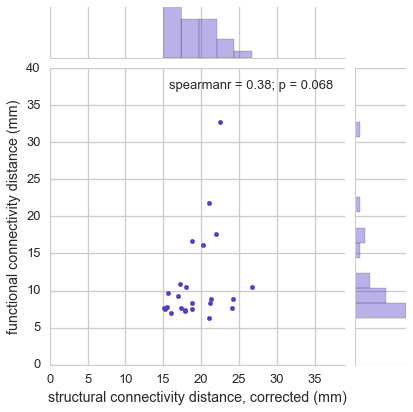

In [88]:
g = sns.jointplot(x="corrected_condist", y="meandist", 
                  data=test[~fltr], kind='scatter', 
                  color="#533cc6", 
                  xlim=(0,39), ylim=(0,40),
                  stat_func=spearmanr)


g.set_axis_labels(xlabel='structural connectivity distance, corrected (mm)',
                  ylabel='functional connectivity distance (mm)')


#plt.xticks([0,10,20,30])
#plt.yticks([0,10,20,30,40])


g.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/similarity_funcstruct.png', dpi=300)

In [102]:
spearmanr(test[~fltr].corrected_condist,
          test[~fltr].meandist)

SpearmanrResult(correlation=0.37913043478260866, pvalue=0.067684664882004295)

# Supplementaries: hypothesis-free analysis

In [74]:
rsqr_norm = np.load('/nobackup/hunte1/sabine/data/tractdist/rsqr_norm.npy')

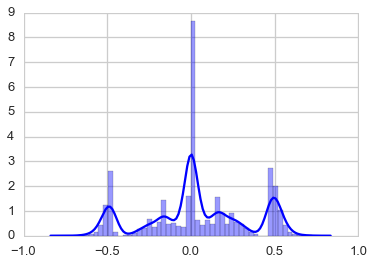

In [75]:
sns.distplot(rsqr_norm)

In [76]:
test['rsqr_norm'] = np.nan

In [77]:
test = test[test.area != '???']

In [78]:
for i in test.index:
    print i
    test['rsqr_norm'].loc[i] = rsqr_norm[test.loc[i].vertices].mean()

0
1
2


/home/raid3/oligschlager/anaconda2/envs/distconnect/lib/python2.7/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/nobackup/hunte1/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


In [79]:
test['rsqr_norm'] = test['rsqr_norm'] * -1

/nobackup/hunte1/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [80]:
fltr = test.area.isin(excl_areas)

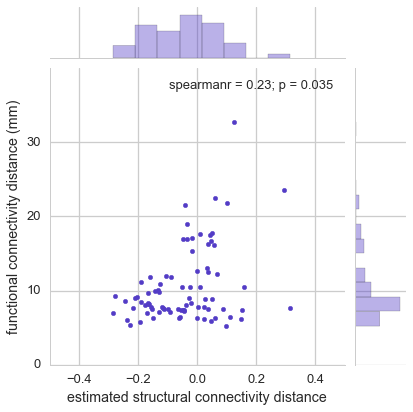

In [86]:
g = sns.jointplot(x="rsqr_norm", y="meandist", 
                  data=test[~fltr], kind='scatter', 
                  color="#533cc6", 
                  xlim=(-0.5,0.5), ylim=(0,40),
                  stat_func=spearmanr)


g.set_axis_labels(xlabel='estimated structural connectivity distance',
                  ylabel='functional connectivity distance (mm)')


plt.xticks([0,10,20,30])
plt.yticks([0,10,20,30])


g.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/similarity_funcopti.png', dpi=300)